In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ndcg_score
from tqdm import tqdm 
from datetime import datetime

from pprint import pprint
from joblib import Parallel, delayed
from evaluation.evaluation import get_stats_dict, get_aggregate_stats, get_anomaly_scores_labels, get_aggregate_stats_concat, get_model_names

import sys
sys.path.append('/home/ubuntu/PyMAD/')
from src.pymad.evaluation.numpy import adjusted_precision_recall_f1_auc

In [11]:
# Path to saved ranking objects
dataset = 'smd'
metric = 'influence'
evaluation_metric = 'Best F-1' # 'PR-AUC' 'Best F-1' 
save_dir = r'/home/ubuntu/efs/results/'
overwrite = False
n_jobs = 8

In [12]:
stats = get_stats_dict(dataset=dataset, metric=metric, evaluation_metric=evaluation_metric, overwrite=overwrite, n_jobs=n_jobs, save_dir=save_dir, verbose=False)

### Aggregate Results per Entity

In [13]:
aggregate_stats = get_aggregate_stats(stats, evaluation_metric=evaluation_metric)

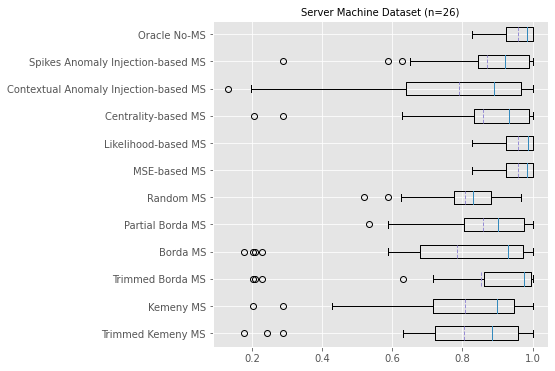

In [14]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharey=True, sharex=True)
    
result_table = {}
axes.set_title(f"Server Machine Dataset (n={len(aggregate_stats['Oracle No-MS/Oracle MS'])})", fontsize=10)    
_ = axes.boxplot([i[1] for i in aggregate_stats.items() if '/' in i[0]], 
                vert=False, 
                bootstrap=10000,
                showmeans=True,
                meanline=True, 
                labels = [i[0].split('/')[0] for i in aggregate_stats.items() if '/' in i[0]])

plt.savefig(f"box_plot_{dataset}_{metric}_{evaluation_metric}_per_entity_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

### Results Table

In [15]:
results_table = {}
for s in aggregate_stats.keys():
    results_table[s] = {}
    results_table[s][f'Mean'] = np.mean(aggregate_stats[s])
    results_table[s][f'Std'] = np.std(aggregate_stats[s])
    results_table[s][f'Median'] = np.median(aggregate_stats[s])
    results_table[s][f'IQR'] = np.quantile(a=aggregate_stats[s], q=0.75) - np.quantile(a=aggregate_stats[s], q=0.25)

results_table = pd.DataFrame(results_table)

In [16]:
results_table.iloc[:, :13]

,Trimmed Kemeny MS,Kemeny MS,Trimmed Borda MS,Borda MS,Partial Borda MS,Oracle MS,Random MS,MSE-based MS,Likelihood-based MS,Centrality-based MS,Contextual Anomaly Injection-based MS,Spikes Anomaly Injection-based MS,Oracle No-MS
Mean,0.765154,0.768966,0.817238,0.748665,0.817587,0.950646,0.768622,0.911310,0.912367,0.818609,0.753066,0.829057,0.911310
Std,0.225432,0.209289,0.248035,0.269147,0.142729,0.046128,0.123163,0.076493,0.076986,0.207576,0.250826,0.174554,0.076493
Median,0.844902,0.855007,0.914097,0.887980,0.865854,0.964553,0.789527,0.926645,0.926645,0.893812,0.850703,0.881763,0.926645
IQR,0.206417,0.238633,0.157735,0.279257,0.199641,0.072987,0.143112,0.114307,0.114307,0.203242,0.328273,0.199701,0.114307


### Aggregate Results with Concatenated Entities

In [17]:
anomaly_scores_all_entities, anomaly_labels_all_entities = get_anomaly_scores_labels(save_dir, dataset)

100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


In [18]:
n_splits = 10
random_state = 0
aggregate_stats = get_aggregate_stats_concat(stats, anomaly_scores_all_entities, anomaly_labels_all_entities, evaluation_metric=evaluation_metric, n_splits=n_splits, random_state=random_state)

7it [04:10, 36.00s/it]

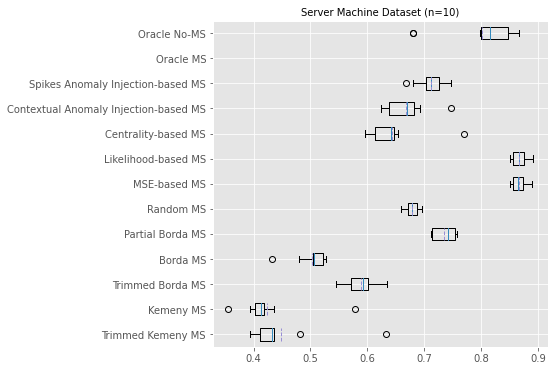

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharey=True, sharex=True)
    
result_table = {}
axes.set_title(f"Server Machine Dataset (n={n_splits})", fontsize=10)    
_ = axes.boxplot(aggregate_stats.values(), 
                vert=False, 
                bootstrap=10000,
                showmeans=True,
                meanline=True, 
                labels = aggregate_stats.keys())
plt.savefig(f"box_plot_{dataset}_{metric}_{evaluation_metric}_concatenated_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
results_table = {}
for s in aggregate_stats.keys():
    if 'Oracle MS' == s: continue
    results_table[s] = {}
    results_table[s][f'Mean'] = np.mean(aggregate_stats[s])
    results_table[s][f'Std'] = np.std(aggregate_stats[s])
    results_table[s][f'Median'] = np.median(aggregate_stats[s])
    results_table[s][f'IQR'] = np.quantile(a=aggregate_stats[s], q=0.75) - np.quantile(a=aggregate_stats[s], q=0.25)

results_table = pd.DataFrame(results_table)

In [ ]:
results_table

,Trimmed Kemeny MS,Kemeny MS,Trimmed Borda MS,Borda MS,Partial Borda MS,Random MS,MSE-based MS,Likelihood-based MS,Centrality-based MS,Contextual Anomaly Injection-based MS,Spikes Anomaly Injection-based MS,Oracle No-MS
Mean,0.447615,0.423467,0.589744,0.502602,0.735737,0.678434,0.866857,0.867415,0.642688,0.667869,0.712414,0.802492
Std,0.066045,0.055454,0.024808,0.026662,0.019171,0.011357,0.013515,0.013601,0.046936,0.035263,0.024021,0.064987
Median,0.432616,0.413795,0.593307,0.506092,0.741148,0.677759,0.865141,0.865919,0.641066,0.670579,0.712660,0.815733
IQR,0.024714,0.015812,0.030018,0.017160,0.040393,0.015505,0.019170,0.018890,0.033000,0.042592,0.023262,0.046358


### Look at the performance of all metrics

In [1]:
ent = list(stats.keys())[0]
metric_names = [i for i in stats[ent].keys() if (('Rank' not in i) and ('Best F-1' in i))]

averages = {}
for ent in stats.keys():
    for m in metric_names:
        if m not in averages.keys():
            averages[m] = 0
        if isinstance(stats[ent][m], np.ndarray):
            averages[m] += stats[ent][m][0]
        else: 
            averages[m] += stats[ent][m]

sorted(averages.items(), key=lambda x: x[1], reverse=True)

NameError: name 'stats' is not defined